Install dependencies

In [1]:
!pip install tensorflow mlflow matplotlib scikit-learn

Kaggle key

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\n  "username": "kartheektelikepalli",\n  "key": "KGAT_adfd0070275b37fafde36b2e1f17cf56"\n}'}

Configure Kaggle API and download the dataset from Kaggle

In [15]:
import os

# Create .kaggle folder
!mkdir -p ~/.kaggle

# Move kaggle.json
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle configured successfully.")
!kaggle datasets download -d tongpython/cat-and-dog


Kaggle configured successfully.
Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
!rm -rf training_set
!rm -rf test_set
!unzip -q cat-and-dog.zip
print("Unzipped successfully.")

Unzipped successfully.


Display sample images

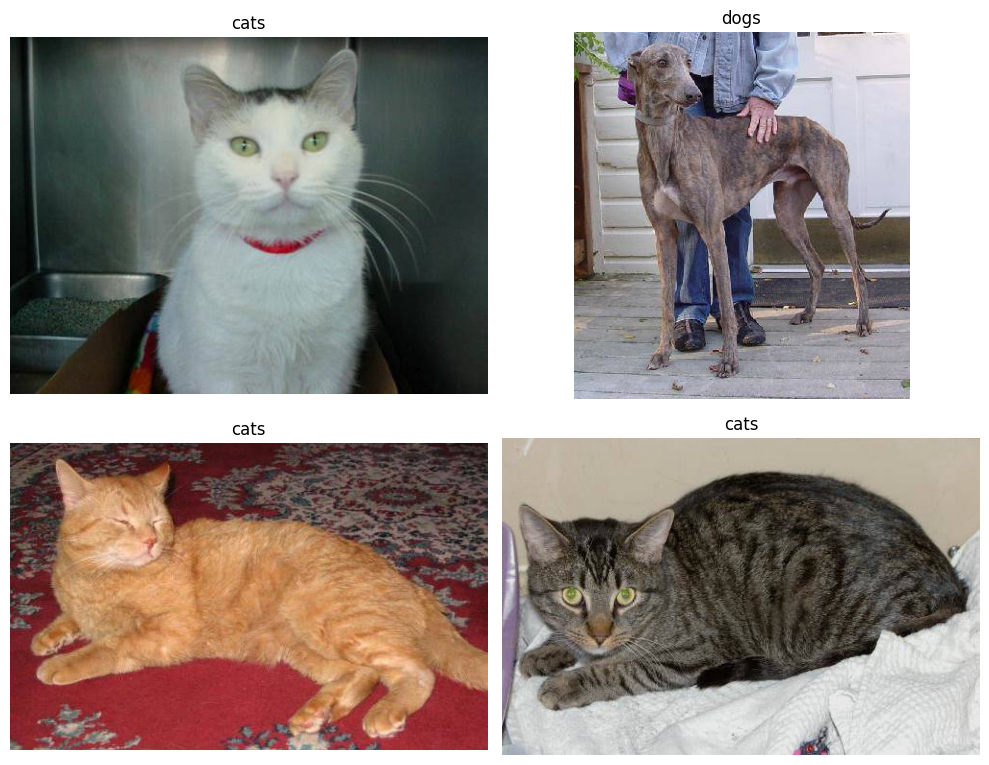

In [18]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_random_images(folder_path, num_images=4):
    class_names = os.listdir(folder_path)

    plt.figure(figsize=(10, 8))

    for i in range(num_images):
        class_name = random.choice(class_names)
        class_folder = os.path.join(folder_path, class_name)
        image_name = random.choice(os.listdir(class_folder))
        image_path = os.path.join(class_folder, image_name)

        img = Image.open(image_path)

        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images("training_set/training_set")


Imports

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

Define Dataset Paths

In [19]:
TRAIN_PATH = "training_set/training_set"
TEST_PATH = "test_set/test_set"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

Load Training Dataset (With Validation Split)

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


Load Test Dataset

In [21]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2023 files belonging to 2 classes.


Enable Prefetch (Performance Optimization)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("Datasets optimized with prefetch.")


Datasets optimized with prefetch.


Define Data Augmentation

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Define Normalization Layer

In [26]:
normalization_layer = layers.Rescaling(1./255)

Build Baseline CNN

In [27]:
def build_baseline_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(224,224,3)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

baseline_model = build_baseline_model()
baseline_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Compile Baseline Model

In [28]:
baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Baseline model compiled.")

Baseline model compiled.


Train Baseline Model

In [29]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [30]:
EPOCHS = 5

history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.5123 - loss: 0.8649 - val_accuracy: 0.5965 - val_loss: 0.6752
Epoch 2/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.5964 - loss: 0.6707 - val_accuracy: 0.6352 - val_loss: 0.6484
Epoch 3/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.6656 - loss: 0.6100 - val_accuracy: 0.6708 - val_loss: 0.6480
Epoch 4/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.7312 - loss: 0.5336 - val_accuracy: 0.6896 - val_loss: 0.6671
Epoch 5/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.8160 - loss: 0.4028 - val_accuracy: 0.6933 - val_loss: 0.7595


The baseline CNN model gave an accuracy of 69.33%, Now let's try MobileNet model

In [31]:
def build_transfer_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224,224,3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False

    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

transfer_model = build_transfer_model()
transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Compile MobileNet Model

In [32]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("MobileNet model compiled.")

MobileNet model compiled.


Train MobileNet Model

In [33]:
EPOCHS = 5

history_transfer = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.8709 - loss: 0.2883 - val_accuracy: 0.9769 - val_loss: 0.0703
Epoch 2/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.9544 - loss: 0.1176 - val_accuracy: 0.9813 - val_loss: 0.0543
Epoch 3/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9544 - loss: 0.1095 - val_accuracy: 0.9831 - val_loss: 0.0520
Epoch 4/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9657 - loss: 0.0920 - val_accuracy: 0.9856 - val_loss: 0.0468
Epoch 5/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.9632 - loss: 0.0899 - val_accuracy: 0.9844 - val_loss: 0.0437


Evaluation on Test Set

In [34]:
test_loss, test_acc = transfer_model.evaluate(test_ds)
print("MobileNet Test Accuracy:", test_acc)

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9831 - loss: 0.0410
MobileNet Test Accuracy: 0.9851705431938171


Save Production Model

In [36]:
import os

os.makedirs("models", exist_ok=True)

transfer_model.save("models/cats_dogs_mobilenet.keras")
print("Model saved in native Keras format.")


Model saved in native Keras format.


Update Inference Loader

In [38]:
MODEL_PATH = "models/cats_dogs_mobilenet.keras"

loaded_model = tf.keras.models.load_model(MODEL_PATH)
transfer_model.save("models/cats_dogs_mobilenet.keras", include_optimizer=False)

Define a Prediction Function

In [47]:
from PIL import Image
import numpy as np

def predict_image(path):
    img = Image.open(path).convert("RGB")
    img = img.resize((224, 224))

    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prob = loaded_model.predict(img_array)[0][0]
    label = "Dog" if prob > 0.5 else "Cat"

    return prob, label


Test with a sample Dog Image

In [48]:
prob, label = predict_image("training_set/training_set/dogs/dog.1.jpg")

print("Probability:", prob)
print("Prediction:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Probability: 0.9975667
Prediction: Dog


Test with a sample Cat Image

In [49]:
prob, label = predict_image("training_set/training_set/cats/cat.1.jpg")

print("Probability:", prob)
print("Prediction:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Probability: 0.0020299067
Prediction: Cat


In [50]:
temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Class names:", temp_ds.class_names)


Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Class names: ['cats', 'dogs']


In [52]:
prob, label = predict_image("training_set/training_set/cats/cat.1.jpg")
print("Cat image probability:", prob, "Prediction:", label)

prob, label = predict_image("training_set/training_set/dogs/dog.1.jpg")
print("Dog image probability:", prob, "Prediction:", label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Cat image probability: 0.0020299067 Prediction: Cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Dog image probability: 0.9975667 Prediction: Dog
